In [98]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [99]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [100]:
batch_size = 64
num_classes = 43

In [112]:
train_dataset = datasets.GTSRB(root='./data',
                                split="train",
                                transform = transforms.Compose([
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(1.,), std = (0.5 ))]),
                                download = True)
test_dataset = datasets.GTSRB(root='./data',
                                split="test",
                                transform = transforms.Compose([
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(1.,), std = (0.5 ))]),
                                download = True)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = batch_size,
                          shuffle = True)

In [113]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [114]:
model = LeNet5(num_classes).to(device)

cost = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [117]:
num_epochs = 4

loss_train = []
loss_test = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    sum_loss = 0
    n_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss
        n_batches += 1
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    loss_train.append(sum_loss / n_batches)

    sum_loss = 0
    n_batches = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        sum_loss += loss
        n_batches += 1
    loss_test.append(sum_loss / n_batches)

Epoch [1/4], Step [100/417], Loss: 0.2808
Epoch [1/4], Step [200/417], Loss: 0.3177
Epoch [1/4], Step [300/417], Loss: 0.3208
Epoch [1/4], Step [400/417], Loss: 0.2293
Epoch [2/4], Step [100/417], Loss: 0.2637
Epoch [2/4], Step [200/417], Loss: 0.2095
Epoch [2/4], Step [300/417], Loss: 0.0371
Epoch [2/4], Step [400/417], Loss: 0.2067
Epoch [3/4], Step [100/417], Loss: 0.0741
Epoch [3/4], Step [200/417], Loss: 0.0257
Epoch [3/4], Step [300/417], Loss: 0.0934
Epoch [3/4], Step [400/417], Loss: 0.0523
Epoch [4/4], Step [100/417], Loss: 0.0247
Epoch [4/4], Step [200/417], Loss: 0.0160
Epoch [4/4], Step [300/417], Loss: 0.0696
Epoch [4/4], Step [400/417], Loss: 0.0629


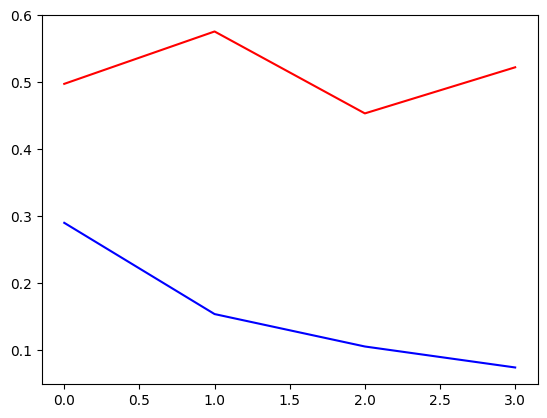

In [118]:
loss_train = np.array(torch.Tensor(loss_train))
loss_test = np.array(torch.Tensor(loss_test))

x = [i for i in range(num_epochs)]

fig, ax = plt.subplots()

ax.plot(x, loss_train, color='blue')
ax.plot(x, loss_test, color='red')

In [119]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 12630 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 12630 test images: 89.73871733966746 %
